# Análise do campo de ML por desenvolvimento do país

Machine Learning uma das área mais emergentes na computação, e diversas técnicas exigem amplo poder computacional. Queremos então estudar como a diferença no desenvolvimento de países, separados em desenvolvidos e emergentes, impactam nessa área - inclusive para o mercado de trabalho.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth
import pysubgroup as ps
import numpy as np
import textwrap


np.seterr(divide='ignore', invalid='ignore')

df = pd.read_csv('./data/processed.csv')
df.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_Coursera,Q6_edX,Q6_Kaggle Learn Courses,Q6_DataCamp,Q6_Fast.ai,...,Q44_Twitter (data science influencers),"Q44_Email newsletters (Data Elixir, O'Reilly Data & AI, etc)","Q44_Reddit (r/machinelearning, etc)","Q44_Kaggle (notebooks, forums, etc)","Q44_Course Forums (forums.fast.ai, Coursera forums, etc)","Q44_YouTube (Kaggle YouTube, Cloud AI Adventures, etc)","Q44_Podcasts (Chai Time Data Science, O’Reilly Data Show, etc)","Q44_Blogs (Towards Data Science, Analytics Vidhya, etc)","Q44_Journal Publications (peer-reviewed journals, conference proceedings, etc)","Q44_Slack Communities (ods.ai, kagglenoobs, etc)"
0,121,30-34,Man,India,No,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,462,30-34,Man,Algeria,No,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,293,18-21,Man,Egypt,Yes,1,1,0,1,0,...,1,1,0,1,0,1,1,0,0,0
3,851,55-59,Man,France,No,1,0,1,0,0,...,1,0,0,1,1,0,0,1,0,0
4,232,45-49,Man,India,Yes,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Dividindo países em desenvolvidos e emergentes/em desenvolvimento

Utilizando ranking do IMF https://www.imf.org/en/Publications/WEO/weo-database/2023/April/groups-and-aggregates

In [25]:
advanced_economies = {
    "Australia", "Belgium", "Canada", "Czech Republic", "France", "Germany",
    "Hong Kong (S.A.R.)", "Ireland", "Israel", "Italy", "Japan", "Netherlands",
    "Portugal", "Singapore", "South Korea", "Spain", "Taiwan",
    "United Kingdom of Great Britain and Northern Ireland",
    "United States of America"
}

emerging_and_developing_economies = {
    "Algeria", "Argentina", "Bangladesh", "Brazil", "Cameroon", "Chile",
    "China", "Colombia", "Ecuador", "Egypt", "Ethiopia", "Ghana", "India",
    "Indonesia", "Iran, Islamic Republic of...", "Kenya", "Malaysia", "Mexico",
    "Morocco", "Nepal", "Nigeria", "Pakistan", "Peru", "Philippines",
    "Poland", "Romania", "Russia", "Saudi Arabia", "South Africa",
    "Sri Lanka", "Thailand", "Tunisia", "Turkey", "Ukraine",
    "United Arab Emirates", "Viet Nam", "Zimbabwe"
}

def set_tier(name):
    if name in advanced_economies:
        return 2
    elif name in emerging_and_developing_economies:
        return 1
    else: return 0

#Create country status, discard other
df['Country-status'] = df['Q4'].apply(set_tier)
df = df[df['Country-status'] != 0]

## Descoberta de subgrupos inicial

Como as perguntas feitas [dependem das respostas iniciais](./data/kaggle_survey_2022_answer_choices.pdf), faz-se primeiro a descoberta de subgrupos para as perguntas "gerais", ou perguntas não gerais que tendem a ter muitas respostas positivas (quantos anos programa).

Não são utilizados colunas que aceitam múltiplas resposta, pois geralmente atrapalham na descoberta. Essas poderão ser analisadas via padrões frequentes

In [41]:
def filter_df(df, questions):
    cols = [*df]
    selected = []
    for q in questions:
        #Get associated columns
        selected.extend([c for c in cols if c == q or c.startswith(q + '_')])
    return df[selected]

filtered = filter_df(df, ['Country-status', 'Q2', 'Q3', 'Q5', 'Q8', 'Q11', 'Q16'])
filtered.head()

,Country-status,Q2,Q3,Q5,Q8,Q11,Q16
0,1,30-34,Man,No,NaN,NaN,NaN
1,1,30-34,Man,No,Master’s degree,1-3 years,Under 1 year
2,1,18-21,Man,Yes,Bachelor’s degree,1-3 years,1-2 years
3,2,55-59,Man,No,Some college/university study without earning ...,10-20 years,1-2 years
4,1,45-49,Man,Yes,Bachelor’s degree,5-10 years,I do not use machine learning methods


### Teste Chi-Quadrado

Primeiro, pegamos os subgrupos com maior significância estatística para realizar uma filtragem dos resultados futuros, já que queremos resultados interessantes, mas também com uma significância alta.

In [42]:
target = ps.BinaryTarget('Country-status', 2)
searchspace = ps.create_selectors(filtered, ignore=['Country-status'])
task = ps.SubgroupDiscoveryTask (
    filtered,
    target,
    searchspace,
    result_set_size=30,
    depth=3,
    qf=ps.ChiSquaredQF())
chi = ps.BeamSearch(beam_width=30).execute(task).to_dataframe()[['quality','subgroup','lift']]

### Países desenvolvidos

Países desenvolvidos tendem a terem menos estudantes, com alto nível de experiência em questão de tempo e diplomas (doutorados). 

In [43]:
target = ps.BinaryTarget('Country-status', 2)
searchspace = ps.create_selectors(filtered, ignore=['Country-status'])
task = ps.SubgroupDiscoveryTask (
    filtered,
    target,
    searchspace,
    result_set_size=10,
    depth=3,
    qf=ps.WRAccQF())
developed = ps.BeamSearch(beam_width=30).execute(task).to_dataframe()[['quality','subgroup','lift']]
developed = pd.merge(developed, chi, 'inner', on='subgroup', suffixes=('WRAcc', 'Chi'))

developed

,qualityWRAcc,subgroup,liftWRAcc,qualityChi,liftChi
0,0.054040,Q5=='No',1.400047,1336.866529,1.400047
1,0.042825,Q3=='Man' AND Q5=='No',1.404566,879.902230,1.404566
2,0.025346,Q11=='20+ years',2.490394,1243.131587,2.490394
3,0.023413,Q11=='20+ years' AND Q5=='No',2.590325,1214.318309,2.590325
4,0.023097,Q11=='20+ years' AND Q3=='Man',2.513520,1142.478521,2.513520
5,0.021425,Q11=='20+ years' AND Q3=='Man' AND Q5=='No',2.622677,1127.075557,2.622677
6,0.017889,Q5=='No' AND Q8=='Doctoral degree',1.941317,558.548985,1.941317


### Países emergentes/em desenvolvimento

Tendem a possuir mais estudantes, com uma tendência maior de homens. Há também uma tendência maior de pessoas jovens e na graduação.

In [49]:
target = ps.BinaryTarget('Country-status', 1)
searchspace = ps.create_selectors(filtered, ignore=['Country-status'])
task = ps.SubgroupDiscoveryTask (
    filtered,
    target,
    searchspace,
    result_set_size=10,
    depth=4,
    qf=ps.WRAccQF())
emerging = ps.BeamSearch().execute(task).to_dataframe()[['quality','subgroup','lift']]

emerging = pd.merge(emerging, chi, 'inner', on='subgroup', suffixes=('WRAcc', 'Chi'))

### Visualizando os resultados

Os subgrupos encontrados acima são contrastantes. Iremos visualizar alguns dos resultados obtidos. Primeiros, iremos visualizar a presença desses subgrupos em contraste com o resto da base de dados, que é o "lift" visualizado pela métrica do WRAcc

In [145]:
#Overall proportion of the target
baseline_prop = df['Country-status'].value_counts(normalize=True)

ans = {'Subgroup': ['Baseline','Baseline'], 'status': list(baseline_prop.keys()), 'proportion': list(baseline_prop.values)}

#Isolate subgroups
for sub in list(emerging['subgroup']) + list(developed['subgroup']):
    sub_df = df[sub.covers(df)]
    prop = sub_df['Country-status'].value_counts(normalize=True)
    for k,v in prop.items():
        ans['Subgroup'].append(sub)
        ans['status'].append(k)
        ans['proportion'].append(v)

prop = pd.DataFrame(ans)
prop.head()

,Subgroup,status,proportion
0,Baseline,1,0.730610
1,Baseline,2,0.269390
2,Q5=='Yes',1,0.839003
3,Q5=='Yes',2,0.160997
4,Q3=='Man' AND Q5=='Yes',1,0.845568


/tmp/ipykernel_13877/207050870.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels)


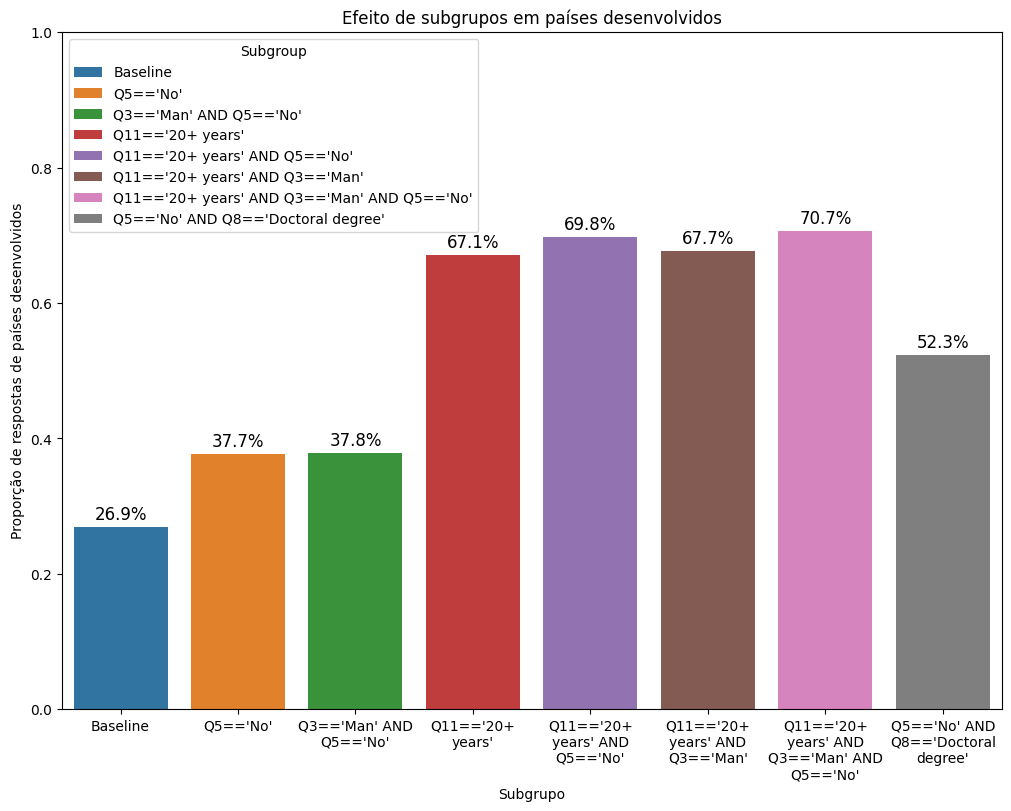

In [163]:
dev_sub = prop[(prop['status'] == 2) & ((prop['Subgroup'].isin(developed['subgroup'])) | (prop['Subgroup'] == 'Baseline'))]

fig, ax = plt.subplots(figsize=(10,8), constrained_layout=True)
sns.barplot(dev_sub, x='Subgroup', y='proportion', hue='Subgroup')

labels = [label.get_text() for label in ax.get_xticklabels()]
wrapped_labels = [textwrap.fill(label, width=15) for label in labels]
ax.set_xticklabels(wrapped_labels)

ax.set_xlabel('Subgrupo')
ax.set_ylabel('Proporção de respostas de países desenvolvidos')
ax.set_ylim(0,1)
ax.set_title("Efeito de subgrupos em países desenvolvidos")

# Add percentage labels on top of the bars
for p in ax.patches:
    if p.get_width() == 0:
        continue
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12,
                xytext=(0, 9),
                textcoords='offset points')

/tmp/ipykernel_13877/4254015039.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels)


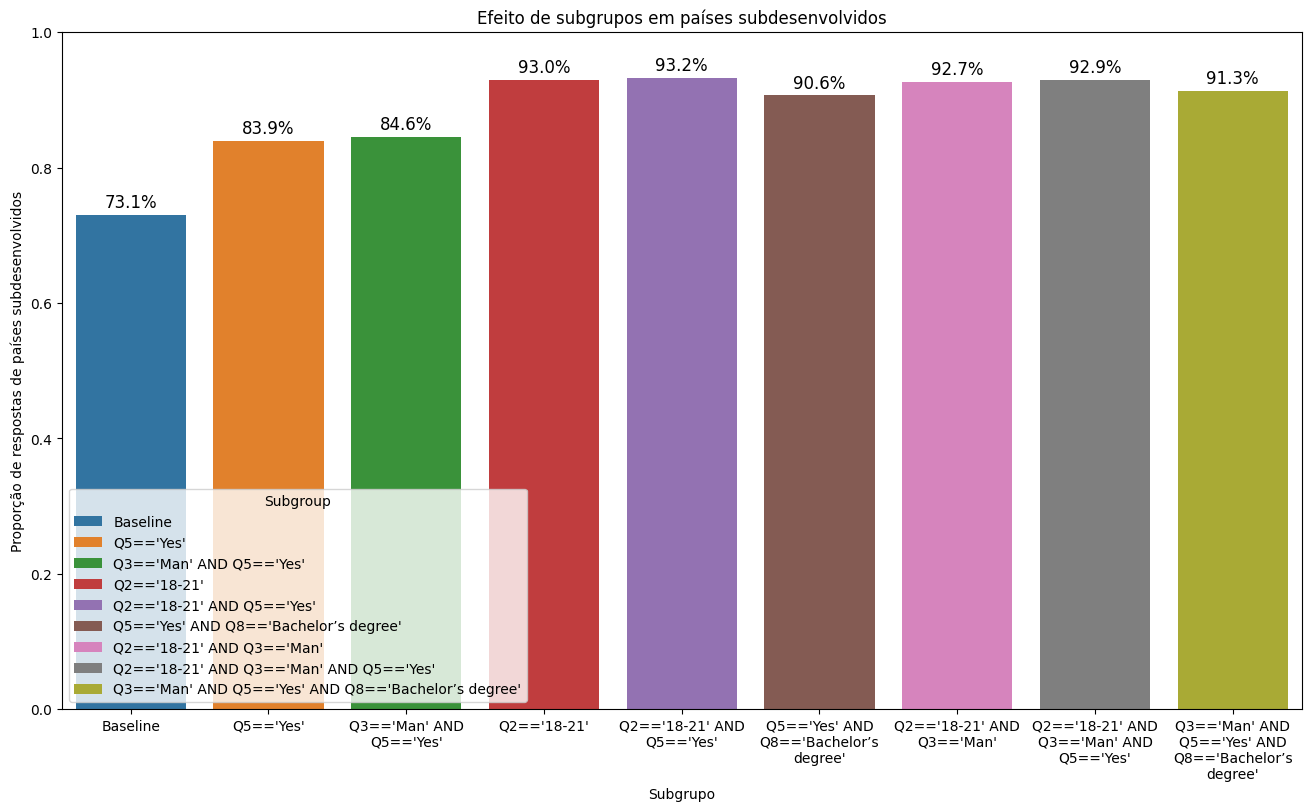

In [168]:
dev_sub = prop[(prop['status'] == 1) & ((prop['Subgroup'].isin(emerging['subgroup'])) | (prop['Subgroup'] == 'Baseline'))]

fig, ax = plt.subplots(figsize=(13,8), constrained_layout=True)
sns.barplot(dev_sub, x='Subgroup', y='proportion', hue='Subgroup')

labels = [label.get_text() for label in ax.get_xticklabels()]
wrapped_labels = [textwrap.fill(label, width=15) for label in labels]
ax.set_xticklabels(wrapped_labels)

ax.set_xlabel('Subgrupo')
ax.set_ylabel('Proporção de respostas de países subdesenvolvidos')
ax.set_ylim(0,1)
ax.set_title("Efeito de subgrupos em países subdesenvolvidos")

# Add percentage labels on top of the bars
for p in ax.patches:
    if p.get_width() == 0:
        continue
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12,
                xytext=(0, 9),
                textcoords='offset points')

#### Número/Proporção de estudantes

O primeiro subgrupo indicado pelo algoritmo é a diferença na presença de estudantes, que aparenta ser bem contrastante. **Os dois outliers nos emergentes/subdesenvolvidos são os Emirados Árabes Únidos e Polônia**.

Text(0.5, 1.0, 'Distribuição das proporções de estudantes')

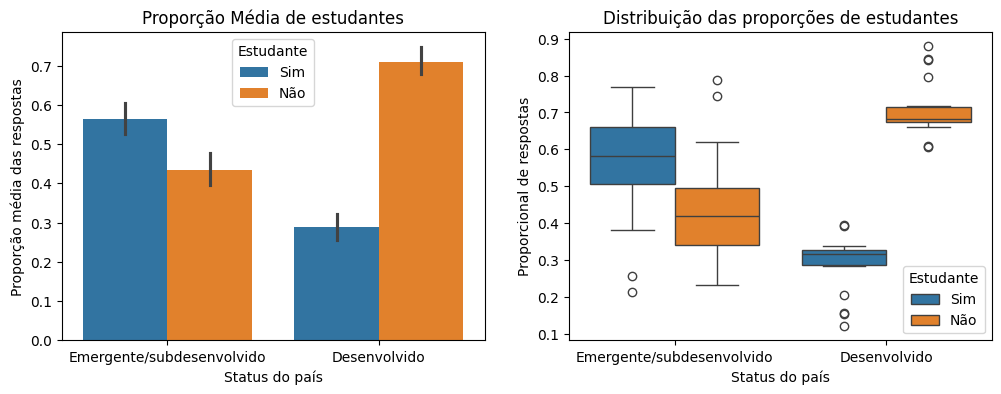

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

prop = df.groupby('Q4')[['Q5', 'Country-status']].value_counts(normalize=True).reset_index().rename(columns={'Q5': 'Estudante'})

prop.replace({'Estudante': {'Yes': 'Sim', 'No': 'Não'},
                         'Country-status': {1: 'Emergente/subdesenvolvido', 2: 'Desenvolvido'}}, inplace=True)

sns.barplot(prop, x='Country-status', y='proportion', hue='Estudante', ax=ax[0], estimator='mean')
sns.boxplot(prop, x='Country-status', y='proportion', hue='Estudante', ax=ax[1])

ax[0].set_xlabel('Status do país')
ax[0].set_ylabel('Proporção média das respostas')
ax[0].set_title('Proporção Média de estudantes')

ax[1].set_xlabel('Status do país')
ax[1].set_ylabel('Proporcional de respostas')
ax[1].set_title('Distribuição das proporções de estudantes')

#### Nível de escolaridade

O nível de escolaridade também aparenta mudar, com os desenvolvidos tendo mais estudantes a nível de mestrado, enquanto os subdesenvolvidos são focados na graduação. Vamos estudar primeiro a distribuições de escolaridade "pura" entre os países. Isso inclui pessoas que já possuem o diploma, ou que estão perto de conseguir tal diploma.

<Axes: xlabel='Country-status', ylabel='proportion'>

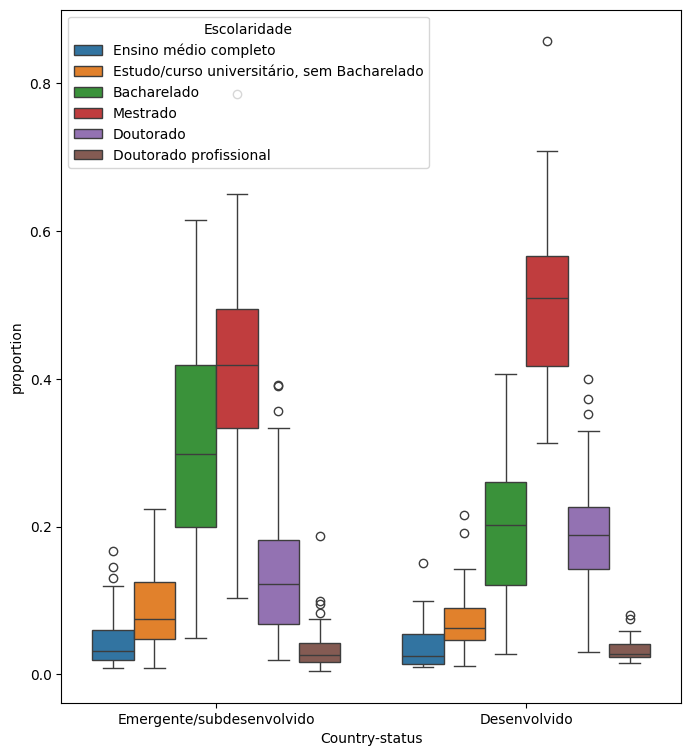

In [32]:
#Filter out not answered
filtered = (df[df['Q8'] != 'I prefer not to answer']).rename(columns={'Q5': 'Estudante', 'Q8': 'Escolaridade'})

scholarity_label = {'No formal education past high school' : 'Ensino médio completo', 
                    'Some college/university study without earning a bachelor’s degree': 'Estudo/curso universitário, sem Bacharelado',
                    'Bachelor’s degree': 'Bacharelado',
                    'Master’s degree': 'Mestrado',
                    'Doctoral degree': 'Doutorado', 
                    'Professional doctorate': 'Doutorado profissional'}

filtered.replace({'Estudante': {'Yes': 'Sim', 'No': 'Não'},
                  'Country-status': {1: 'Emergente/subdesenvolvido', 2: 'Desenvolvido'},
                  'Escolaridade': scholarity_label}, inplace=True)

prop = (filtered.groupby(['Q4', 'Estudante'])[['Escolaridade', 'Country-status']]
        .value_counts(normalize=True)
        .reset_index())

fig,ax = plt.subplots(figsize=(8,9))

sns.boxplot(prop, x='Country-status', y='proportion', hue='Escolaridade', hue_order=list(scholarity_label.values()), ax=ax)

Agora, vamos analisar a distribuição de escolaridade, só que separando os estudantes "formados" com aqueles ativos. Queremos especificamente visualizar os subgrupos `Q5=='Yes' AND Q8=='Bachelor’s degree'` para os subdesenvolvidos e `Q5=='No' AND Q8=='Master’s degree'` para os desenvolvidos

(0.0, 1.0)

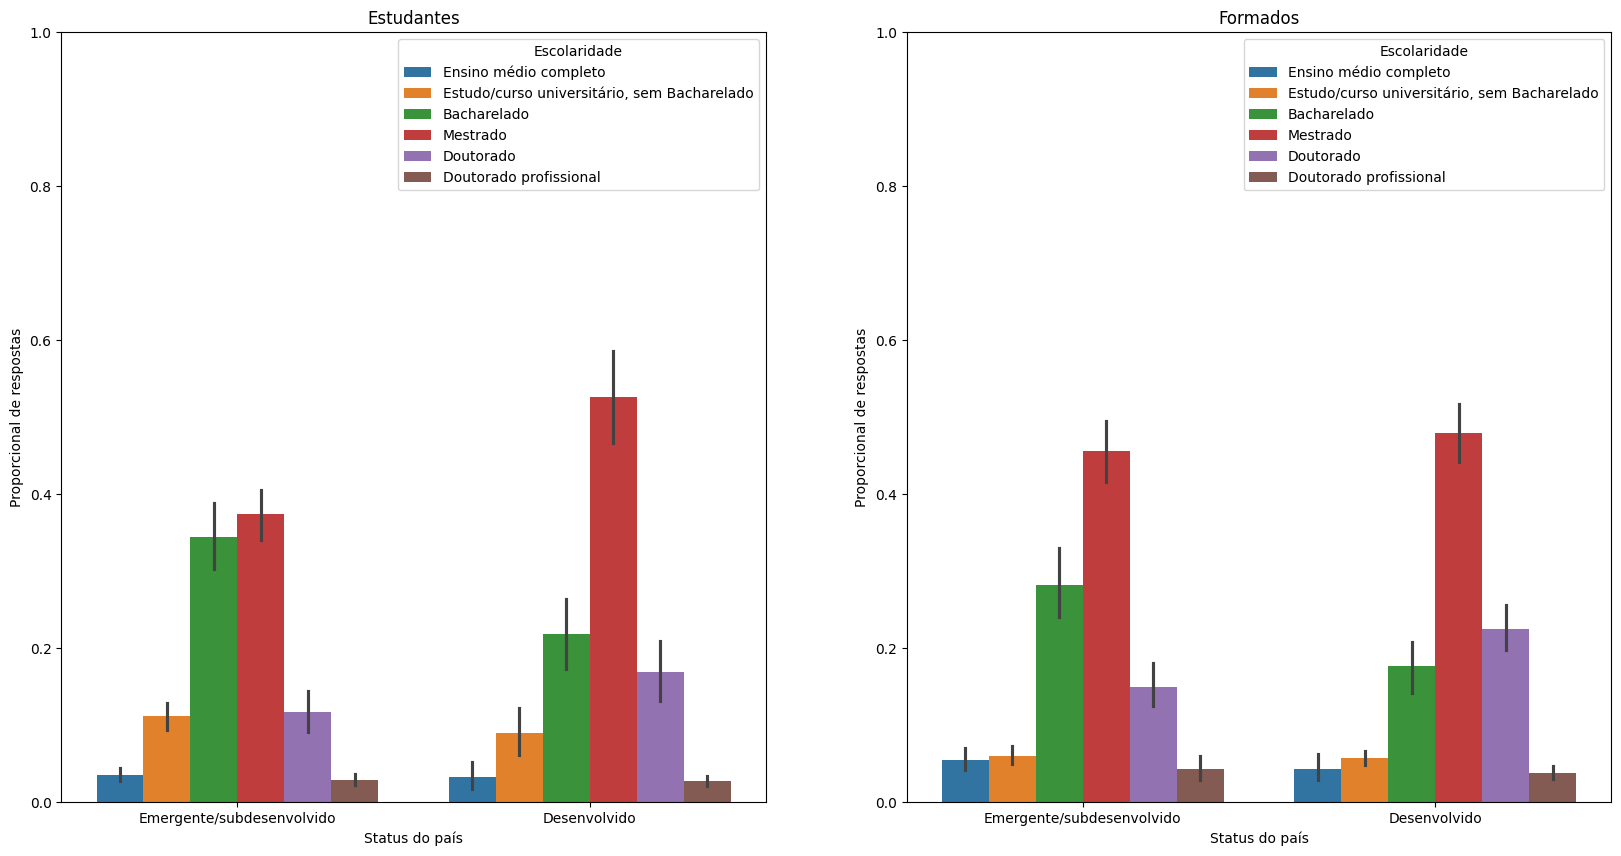

In [33]:
studying = filtered[filtered['Estudante'] == 'Sim']
graduated = filtered[filtered['Estudante'] == 'Não']

prop_studying = (studying.groupby(['Q4'])[['Escolaridade', 'Country-status']]
                 .value_counts(normalize=True)
                 .reset_index())

prop_graduated = (graduated.groupby(['Q4'])[['Escolaridade', 'Country-status']]
                  .value_counts(normalize=True)
                  .reset_index())

fig, ax = plt.subplots(1,2, figsize=(20,10))

sns.barplot(prop_studying, x='Country-status', y='proportion', hue='Escolaridade', hue_order=list(scholarity_label.values()), ax=ax[0])
sns.barplot(prop_graduated, x='Country-status', y='proportion', hue='Escolaridade', hue_order=list(scholarity_label.values()), ax=ax[1])

ax[0].set_xlabel('Status do país')
ax[0].set_ylabel('Proporcional de respostas')
ax[0].set_title('Estudantes')
ax[0].set_ylim(0,1)

ax[1].set_xlabel('Status do país')
ax[1].set_ylabel('Proporcional de respostas')
ax[1].set_title('Formados')
ax[1].set_ylim(0,1)

### Anos de experiência

Os dois grupos também se mostraram diferentes nos anos de experiência

<Axes: xlabel='Country-status', ylabel='proportion'>

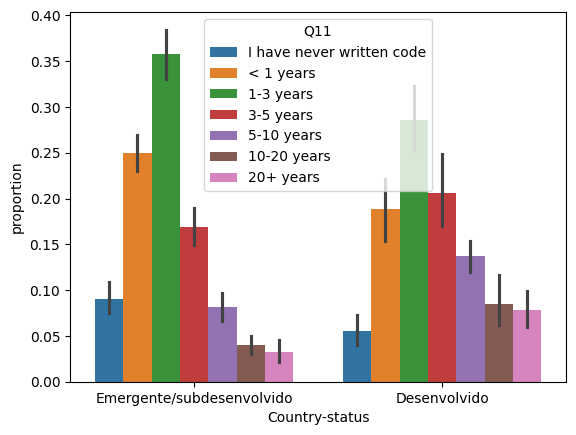

In [34]:
prop_experience = (studying.groupby(['Q4'])[['Q11', 'Country-status']]
                    .value_counts(normalize=True)
                    .reset_index())
prop_ML = (studying.groupby(['Q4'])[['Q16', 'Country-status']]
                    .value_counts(normalize=True)
                    .reset_index())

exp_order = {'I have never written code': 'Nunca escreveu código', '< 1 years': '< 1 anos', '1-3 years': '1-3 anos', '3-5 years': '3-5 anos', 
             '5-10 years': '5-10 anos', '10-20 years': '10-20 anos', '20+ years': '20+ anos'}

sns.barplot(prop_experience, x='Country-status', y='proportion', hue='Q11', hue_order=exp_order.keys())

<Axes: xlabel='Country-status', ylabel='proportion'>

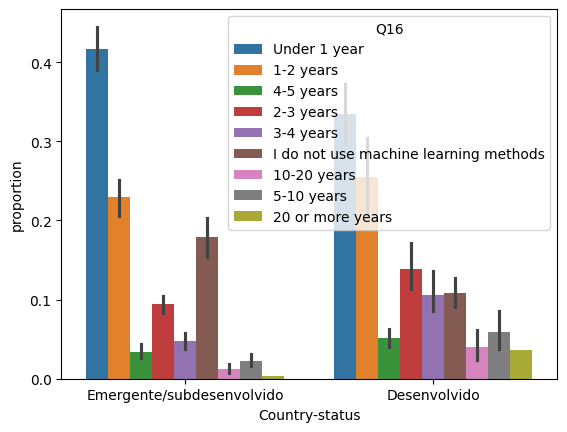

In [35]:
sns.barplot(prop_ML, x='Country-status', y='proportion', hue='Q16')

## Descoberta de subgrupos no mercado de trabalho de ML

Queremos descobrir subgrupos dentro daqueles empregados na área de ML, para podermos utilizar as questões relacionadas à indústria

In [36]:
employed = df[(df['Q5'] == 'No') & (df['Q23'] != 'Currently not employed')]
employed = filter_df(employed, ['Country-status', 'Q8', 'Q16', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q29', 'Q30']).dropna()
employed.head()

,Country-status,Q8,Q16,Q23,Q24,Q25,Q26,Q27,Q29,Q30
3,2,Some college/university study without earning ...,1-2 years,Data Scientist,Online Service/Internet-based Services,0-49 employees,1-2,"We recently started using ML methods (i.e., mo...","25,000-29,999","$1000-$9,999"
7,2,Bachelor’s degree,4-5 years,Software Engineer,Insurance/Risk Assessment,250-999 employees,20+,"We have well established ML methods (i.e., mod...","100,000-124,999",$0 ($USD)
8,2,Doctoral degree,5-10 years,Research Scientist,Government/Public Service,"1000-9,999 employees",20+,"We recently started using ML methods (i.e., mo...","100,000-124,999",$100-$999
13,2,Doctoral degree,5-10 years,Developer Advocate,Computers/Technology,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","200,000-249,999",$100-$999
16,2,Master’s degree,5-10 years,Data Scientist,Computers/Technology,"1000-9,999 employees",3-4,"We have well established ML methods (i.e., mod...","200,000-249,999","$100,000 or more ($USD)"


### Países desenvolvidos

Na maioria dos empregados, há uma forte tendência a usar métodos de ML estabelecidos, assim como altos salários e doutorados.

In [37]:
target = ps.BinaryTarget('Country-status', 2)
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q4'])
task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=10,
    depth=3,
    qf=ps.ChiSquaredQF())
result = ps.BeamSearch(beam_width=40).execute(task)

for x in result.to_dataframe()['subgroup']:
    print(x)
result.to_dataframe()[['quality', 'subgroup', 'lift']]

Q29=='150,000-199,999'
Q29=='$0-999'
Q29=='100,000-124,999'
Q29=='125,000-149,999'
Q29=='10,000-14,999'
Q29=='1,000-1,999'
Q29=='150,000-199,999' AND Q8=='Master’s degree'
Q27=='We have well established ML methods (i.e., models in production for more than 2 years)' AND Q8=='Doctoral degree'
Q26=='20+' AND Q29=='150,000-199,999'
Q29=='200,000-249,999'


,quality,subgroup,lift
0,360.241228,"Q29=='150,000-199,999'",2.206122
1,302.518606,Q29=='$0-999',0.341011
2,282.745917,"Q29=='100,000-124,999'",1.989800
3,255.087223,"Q29=='125,000-149,999'",2.163223
4,219.776112,"Q29=='10,000-14,999'",0.171739
5,203.829908,"Q29=='1,000-1,999'",0.133789
6,178.660413,"Q29=='150,000-199,999' AND Q8=='Master’s degree'",2.186471
7,175.108564,Q27=='We have well established ML methods (i.e...,1.872253
8,166.447346,"Q26=='20+' AND Q29=='150,000-199,999'",2.277902
9,160.222042,"Q29=='200,000-249,999'",2.205632


### Países subdesenvolvidos

A maioria dos empregados é extremamente novo na área, não chegando a usar ML em seus trabalhos. Também há um destaque maior de graduandos, assim como o baixo gasto em serviços na nuvem.

In [38]:
target = ps.BinaryTarget('Country-status', 1)
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q4'])
task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=10,
    depth=4,
    qf=ps.WRAccQF())
result = ps.BeamSearch().execute(task)

for x in result.to_dataframe()['subgroup']:
    print(x)
result.to_dataframe()

Q29=='$0-999'
Q16=='Under 1 year'
Q27=='No (we do not use ML methods)'
Q8=='Bachelor’s degree'
Q29=='10,000-14,999'
Q29=='1,000-1,999'
Q30=='$1-$99'
Q29=='$0-999' AND Q30=='$0 ($USD)'
Q16=='Under 1 year' AND Q8=='Master’s degree'
Q23=='Data Analyst (Business, Marketing, Financial, Quantitative, etc)'


,quality,subgroup,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.033741,Q29=='$0-999',845,6930,724,4020,6085,0.121934,0.878066,0.180100,0.819900,0.856805,0.541660,0.580087,1.477029
1,0.029437,Q16=='Under 1 year',1617,6930,1142,4020,5313,0.233333,0.766667,0.284080,0.715920,0.706246,0.541690,0.580087,1.217484
2,0.022080,Q27=='No (we do not use ML methods)',1417,6930,975,4020,5513,0.204473,0.795527,0.242537,0.757463,0.688073,0.552331,0.580087,1.186156
3,0.021361,Q8=='Bachelor’s degree',1679,6930,1122,4020,5251,0.242280,0.757720,0.279104,0.720896,0.668255,0.551895,0.580087,1.151992
4,0.020878,"Q29=='10,000-14,999'",416,6930,386,4020,6514,0.060029,0.939971,0.096020,0.903980,0.927885,0.557875,0.580087,1.599562
5,0.018685,"Q29=='1,000-1,999'",356,6930,336,4020,6574,0.051371,0.948629,0.083582,0.916418,0.943820,0.560389,0.580087,1.627033
6,0.018678,Q30=='$1-$99',1187,6930,818,4020,5743,0.171284,0.828716,0.203483,0.796517,0.689132,0.557548,0.580087,1.187982
7,0.016174,Q29=='$0-999' AND Q30=='$0 ($USD)',386,6930,336,4020,6544,0.055700,0.944300,0.083582,0.916418,0.870466,0.562958,0.580087,1.500580
8,0.015255,Q16=='Under 1 year' AND Q8=='Master’s degree',709,6930,517,4020,6221,0.102309,0.897691,0.128607,0.871393,0.729196,0.563093,0.580087,1.257047
9,0.015092,"Q23=='Data Analyst (Business, Marketing, Finan...",1104,6930,745,4020,5826,0.159307,0.840693,0.185323,0.814677,0.674819,0.562135,0.580087,1.163307


In [39]:
emerging = ps.EqualitySelector('Country-status', 1)
woman = ps.EqualitySelector('Q3', 'Woman')

target = ps.BinaryTarget(target_selector = ps.Conjunction([emerging, woman]))
searchspace = ps.create_selectors(employed, ignore=['Country-status', 'Q3'])

task = ps.SubgroupDiscoveryTask (
    employed,
    target,
    searchspace,
    result_set_size=5,
    depth=4,
    qf=ps.WRAccQF())

result = ps.BeamSearch().execute(task)
result.to_dataframe()

KeyError: 'Q3'